## Creating and using custom datasets with PyTorch
This example show how one can take data, in the form of NumPy ndarrays, and create a custom dataset for use in PyTorch. For some reasons, all of the major deep-learning libraries take care to include, for uninitiated users, documentation which shows how to instantiate and train a basic neural network. However, by importing the dataset through their helper Dataset modules, they fail to instruct users how to take their own data and modify it so that it can become a useable dataset within the library framework. This example does NOT use torchvisixon's Dataset module to import the MNIST dataset, rather it reads the data from a NumPy "npz" file and transforms that into a dataset using a custom dataset class.

In [20]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms as T 
from torch.optim.lr_scheduler import StepLR 
import torchsummary 
from tqdm.notebook import tqdm as tqdm

In [21]:
datapath = "/home/sylvanix/data/mnist.npz"
with np.load(datapath) as f:
    X_train, y_train = f['x_train'], f['y_train']
    X_test, y_test = f['x_test'], f['y_test']

print("train:", X_train.shape, y_train.shape)
print("test:", X_test.shape, y_test.shape)

train: (60000, 28, 28) (60000,)
test: (10000, 28, 28) (10000,)


In [22]:
# Dataset class for MNIST
class MNIST_Dataset(Dataset):
    
    def __init__(self, train=True, transform=T.ToTensor()):
        if train:
            self.data = X_train.astype(np.float32)
            self.y = y_train
            
        else:
            self.data = X_test.astype(np.float32)
            self.y = None
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = np.array(self.data[index, :])
        img = img.reshape(28, 28, 1)
        img = img / 255 # Normalization
        if self.transform:
            img = self.transform(img)
            
        if self.y is not None:
            return (img, self.y[index]) # (X, Y)
        else:
            return img # Only X

In [23]:
#Dataset class for MNIST
class MNIST_Dataset(Dataset):
    def __init__(self, data_tuple, train=True, transform=T.ToTensor()):
        self.transform = transform
        if train:
            self.data = data_tuple[0].astype(np.float32)
            self.y = data_tuple[1]
        else:
            self.data = data_tuple[0].astype(np.float32)
            self.y = data_tuple[1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index, :]
        img = img.reshape(28, 28, 1)
        img = img / 255

        if self.transform:
            img = self.transform(img)
            
        if self.y is not None:
            return (img, self.y[index])
        else:
            return img

In [24]:
dataset_train = MNIST_Dataset((X_train, y_train), train=True)
dataset_test = MNIST_Dataset((X_test, y_test), train=False)

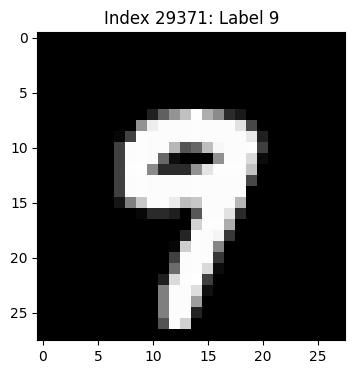

In [25]:
import matplotlib.pyplot as plt
# Showing an img from train set at random
fig, ax = plt.subplots(1, 1, figsize=(8,4))
idx = np.random.choice(np.arange(len(dataset_train)))
img, label = dataset_train[idx]
ax.set(title=f'Index {idx}: Label {label}')
ax.imshow(img.squeeze(),cmap = 'gray')

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(model, device, train_loader, optimizer, epoch, log_interval, dry_run):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [36]:
def main():
    # Training settings
    batch_size = 64
    test_batch_size = 1000
    epochs = 14
    lr = 1.0
    gamma = 0.7
    no_cuda = True
    no_mps = False
    dry_run = False,
    seed = 1
    log_interval = 10
    save_model = False

    use_cuda = not no_cuda and torch.cuda.is_available()
    use_mps = not no_mps and torch.backends.mps.is_available()

    torch.manual_seed(seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': batch_size}
    test_kwargs = {'batch_size': test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=T.Compose([
        T.ToTensor(),
        T.Normalize((0.1307,), (0.3081,))
        ])

    train_loader = torch.utils.data.DataLoader(dataset_train,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, log_interval, dry_run)
        test(model, device, test_loader)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


if __name__ == '__main__':
    main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303652

Test set: Average loss: 2.2840, Accuracy: 1010/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.270616

Test set: Average loss: 2.2126, Accuracy: 4139/10000 (41%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.139745

Test set: Average loss: 2.1485, Accuracy: 3307/10000 (33%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.016997

Test set: Average loss: 2.0845, Accuracy: 3708/10000 (37%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.885655

Test set: Average loss: 2.0188, Accuracy: 4684/10000 (47%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 1.867066

Test set: Average loss: 1.9655, Accuracy: 4472/10000 (45%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.815683

Test set: Average loss: 1.9202, Accuracy: 4821/10000 (48%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 1.727440

Test set: Average loss: 1.8913, Accuracy: 4915/10000 (49%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 1.690157

Test set: Average loss: 1.8699, Accuracy: 4952/10000 (50%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 1.686164
